# Assignment 1 - Edmund Car Reviews - Notebook 3 (Task B, C, D, E, F, G, H)

**Team Members - MSBA '24 Morning Cohort:**
- Karthick Vel Kathirvel (kk37347)
- Sharan Arora (sa44827)
- Spandan Pal (sp54969)
- Manideep Telukuntla (mt39528)
- Pritesh Singh (ps35762)
- Raghav Vaidya (rv25256)


## Task B

Find the top 10 brands from frequency counts. You will need to write a script to count the
frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with
brands so that from now on you have to deal with only brands and not models. You will need another
script for this job. A list of model and brand names (not exhaustive) are provided in a separate file. Even
if a brand (e.g., BMW) is mentioned multiple times in a message, it should be counted as 1.

In [1]:
import pandas as pd
import re
from collections import Counter
import itertools
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
commentsDataTotal = pd.read_csv(r"DiscussionData.csv")
# Drop NaN values
commentsDataTotal = commentsDataTotal.dropna(subset=['Text'])
commentsDataTotal['Time'] = pd.to_datetime(commentsDataTotal['Time'])
sortedCommentsData = commentsDataTotal.sort_values(by='Time', ascending=False)

# Filter to include only the latest 6000 posts
commentsData = sortedCommentsData.head(6000)

# Load the brand-model mapping dataset
brandModelData = pd.read_csv(r"car_models_and_brands.csv")

In [3]:
#import stopwords from nltk
from nltk.corpus import stopwords
stopWords  = set(stopwords.words('english'))

In [4]:
def preprocessText(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stopWords])
    return text

# Apply preprocessing to each text
commentsData['ProcessedText'] = commentsData['Text'].apply(preprocessText)

In [5]:
brandModelData['Brand'] = brandModelData['Brand'].str.lower()
brandModelData['Model'] = brandModelData['Model'].str.lower()

In [6]:
# Create a dictionary to map models to brands
modelToBrandDict = dict(zip(brandModelData['Model'], brandModelData['Brand']))

In [7]:
# Function to replace model names with brand names in a text
def replaceModelWithBrand(text):
    words = text.split()
    replacedWords = [modelToBrandDict.get(word, word) for word in words]
    return ' '.join(replacedWords)

In [8]:
# Replace model names with brand names
commentsData['ProcessedTextBrands'] = commentsData['ProcessedText'].apply(replaceModelWithBrand)

In [9]:
allWords = ' '.join(commentsData['ProcessedTextBrands']).split()
brandWords = [word for word in allWords if word in set(brandModelData['Brand'])]
brandFrequency = Counter(brandWords)

In [10]:
brandFrequency.most_common(14)

[('car', 5494),
 ('bmw', 2003),
 ('audi', 1467),
 ('acura', 1312),
 ('honda', 949),
 ('seat', 594),
 ('volkswagen', 469),
 ('sedan', 424),
 ('infiniti', 395),
 ('cadillac', 379),
 ('hyundai', 358),
 ('toyota', 345),
 ('problem', 309),
 ('ford', 275)]

In [11]:
brandsChosen = ['bmw', 'audi', 'acura', 'honda', 'volkswagen', 'infiniti', 'cadillac', 'hyundai', 'toyota', 'ford']

## Task C

Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have
to write a script to do this task). For lift calculations, be sure not to count a mention more than once
per post, even if it is mentioned multiple times in the post. In your code, ensure that a message is not
counted in the lift calculations if the mentions of two brands are separated by more than, say, 5 or 7
words.


In [12]:
# Initialize dictionaries to hold frequency counts and co-occurrence counts
brandFrequencyDict = {brand: 0 for brand in brandsChosen}
coOccurrenceDict = {(brand1, brand2): 0 for brand1 in brandsChosen for brand2 in brandsChosen if brand1 != brand2}

In [13]:
# Function to update co-occurrence counts based on a single post 
def updateCoOccurrenceRevised(text):

    # Extract unique brand mentions in the text
    words = text.split()
    uniqueBrands = list(set([word for word in words if word in brandsChosen]))

    # Update frequency counts (each brand is counted only once per post)
    for brand in uniqueBrands:
        brandFrequencyDict[brand] += 1

    # Update co-occurrence counts
    for brand1, brand2 in itertools.combinations(uniqueBrands, 2):
        # Check if the distance between the two brands in the post is less than or equal to 7 words
        indices1 = [i for i, x in enumerate(words) if x == brand1]
        indices2 = [i for i, x in enumerate(words) if x == brand2]
        if any(abs(i1 - i2) <= 7 for i1 in indices1 for i2 in indices2):
            coOccurrenceDict[(brand1, brand2)] += 1

# Update frequency and co-occurrence counts based on the posts
commentsData['ProcessedTextBrands'].apply(updateCoOccurrenceRevised)

32      None
31      None
30      None
29      None
28      None
        ... 
5998    None
5997    None
5996    None
5995    None
5994    None
Name: ProcessedTextBrands, Length: 6000, dtype: object

In [14]:
# Initialize a new dictionary to hold the summed values
summedCoOccurrenceDict = {}
# Loop through the original dictionary to sum up the values for each unique pair
for (brand1, brand2), count in coOccurrenceDict.items():
    # Sort the brands lexicographically to ensure uniqueness
    sorted_pair = tuple(sorted((brand1, brand2)))
    # Sum the counts
    if sorted_pair in summedCoOccurrenceDict:
        summedCoOccurrenceDict[sorted_pair] += count
    else:
        summedCoOccurrenceDict[sorted_pair] = count

In [15]:
totalPosts = len(commentsData)
liftRatios = {}
for (brand1, brand2), coOccurCount in summedCoOccurrenceDict.items():
    freq1 = brandFrequencyDict[brand1]
    freq2 = brandFrequencyDict[brand2]
    lift = (totalPosts * coOccurCount) / (freq1 * freq2)
    liftRatios[(brand1, brand2)] = lift
sortedLiftRatios = sorted(liftRatios.items(), key=lambda x: x[1], reverse=True)

# Filter to keep only unique pairs for lift ratios
uniqueLiftRatios = {(min(brand1, brand2), max(brand1, brand2)): lift for (brand1, brand2), lift in sortedLiftRatios}
sortedUniqueLiftRatios = sorted(uniqueLiftRatios.items(), key=lambda x: x[1], reverse=True)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

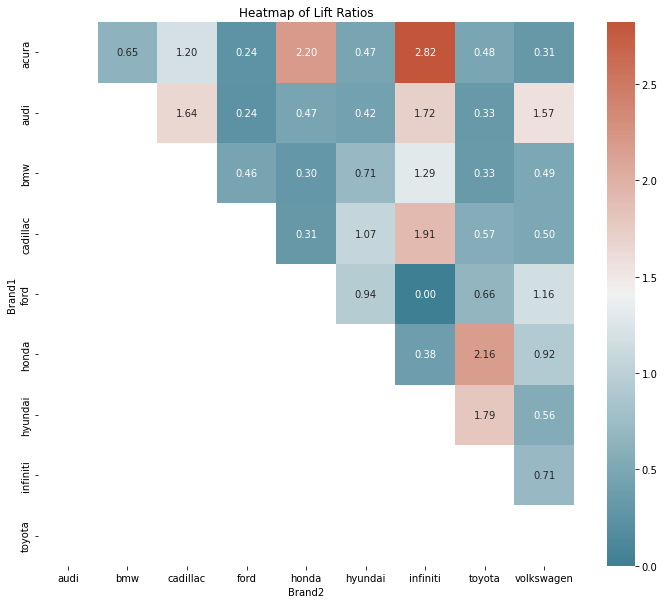

In [48]:
sortedUniqueLiftRatios = pd.DataFrame(sortedUniqueLiftRatios, columns=['Pairs', 'LiftRatio'])
sortedUniqueLiftRatios['Brand1'] = sortedUniqueLiftRatios['Pairs'].apply(lambda x: x[0])
sortedUniqueLiftRatios['Brand2'] = sortedUniqueLiftRatios['Pairs'].apply(lambda x: x[1])

cmap = sns.diverging_palette(220, 20, as_cmap=True, center="light")

# Creating a pivot table for the heatmap
heatmapData = pd.pivot_table(sortedUniqueLiftRatios, values='LiftRatio', index='Brand1', columns='Brand2')

# Filling NaN values with 0 for better representation
heatmapData.fillna(0, inplace=True)

# Creating a mask for the upper triangle
mask = np.tril(np.ones_like(heatmapData, dtype=bool))

# Generating the heatmap, applying the mask
plt.figure(figsize=(12, 10))
sns.heatmap(heatmapData, annot=True, cmap=cmap, fmt=".2f", mask=mask)
plt.title('Heatmap of Lift Ratios')
plt.show()

## Task D

Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there
are multiple scripts available on GitHub).

In [28]:
sortedUniqueLiftRatios

,Pairs,LiftRatio,Brand1,Brand2
0,"(acura, infiniti)",2.821014,acura,infiniti
1,"(acura, honda)",2.200812,acura,honda
2,"(honda, toyota)",2.161166,honda,toyota
3,"(cadillac, infiniti)",1.912351,cadillac,infiniti
4,"(hyundai, toyota)",1.787234,hyundai,toyota
5,"(audi, infiniti)",1.718415,audi,infiniti
6,"(audi, cadillac)",1.643132,audi,cadillac
7,"(audi, volkswagen)",1.574796,audi,volkswagen
8,"(audi, bmw)",1.556539,audi,bmw
9,"(bmw, infiniti)",1.291003,bmw,infiniti


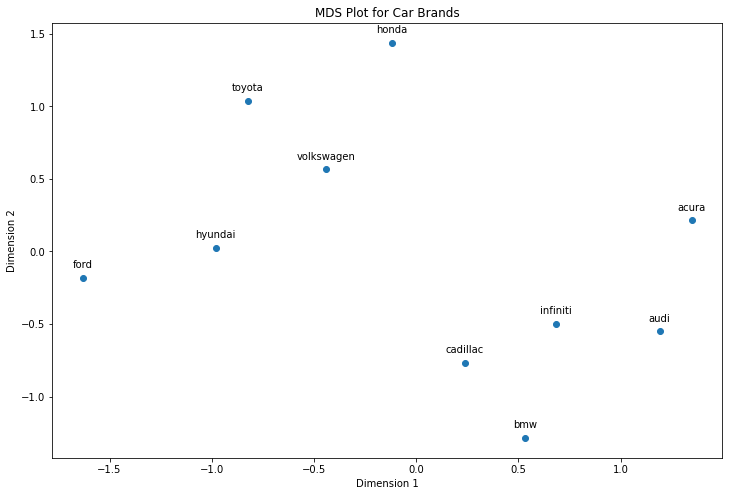

In [29]:
from sklearn.manifold import MDS

# Extract unique brands
unique_brands = list(set(sortedUniqueLiftRatios['Brand1']).union(set(sortedUniqueLiftRatios['Brand2'])))
num_brands = len(unique_brands)

# Create a dissimilarity matrix
dissimilarity_matrix = pd.DataFrame(data=0, index=unique_brands, columns=unique_brands, dtype=float)

# Populate the dissimilarity matrix with 1/lift values
for _, row in sortedUniqueLiftRatios.iterrows():
    brand1 = row['Brand1']
    brand2 = row['Brand2']
    lift = row['LiftRatio']
    dissimilarity_matrix.at[brand1, brand2] = 1 / lift if lift != 0 else 1
    dissimilarity_matrix.at[brand2, brand1] = 1 / lift if lift != 0 else 1

# Fit the MDS model
mds = MDS(n_components=2, random_state=1, dissimilarity="precomputed")
results = mds.fit(dissimilarity_matrix)

# Get coordinates
coords = results.embedding_

# Create the MDS plot
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate the points
for label, x, y in zip(unique_brands, coords[:, 0], coords[:, 1]):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('MDS Plot for Car Brands')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## Task E

What insights can you offer to your client from your analyses in Tasks C and D?

<h2>Insights</h2>

<table border="1">
    <tr>
        <th>Analysis Type</th>
        <th>Insight Category</th>
        <th>Description</th>
    </tr>
    <!-- MDS Coordinates -->
    <tr>
        <td rowspan="3">MDS Coordinates</td>
        <td>Cluster of Luxury Brands</td>
        <td>Brands like 'bmw', 'audi', and 'infiniti' are grouped closely together, suggesting they are perceived similarly, likely as luxury or high-end brands.</td>
    </tr>
    <tr>
        <td>Mainstream vs. Luxury</td>
        <td>'honda' and 'toyota' are distanced from luxury brands like 'bmw', indicating a differentiation in the market perception between mainstream and luxury brands.</td>
    </tr>
    <tr>
        <td>Isolated Brands</td>
        <td>'ford' and 'honda' appear as outliers, suggesting they are unique in certain aspects compared to other brands.</td>
    </tr>
    <!-- Lift Values -->
    <tr>
        <td rowspan="3">Lift Values</td>
        <td>Affinity Between Luxury Brands</td>
        <td>High lift values for combinations like ('audi', 'infiniti') and ('bmw', 'audi') show that these luxury brands often appear together, suggesting a strong affinity among consumers for these brands.</td>
    </tr>
    <tr>
        <td>Mainstream Affinities</td>
        <td>High lift values between ('honda', 'toyota') and ('hyundai', 'toyota') suggest that these mainstream brands share a lot of similarities in consumer perception.</td>
    </tr>
    <tr>
        <td>Mixed Affinities</td>
        <td>Brands like 'audi' and 'volkswagen' have a significant lift value, indicating that consumers often consider these brands together, despite one being a luxury brand and the other more mainstream.</td>
    </tr>
    <!-- Integrated Insights -->
    <tr>
        <td rowspan="4">Integrated Insights</td>
        <td>Cross-Segment Appeal</td>
        <td>'audi' seems to have a broader appeal, as indicated by high lift values with both luxury ('bmw', 'infiniti') and non-luxury ('volkswagen') brands. This could be a unique selling proposition.</td>
    </tr>
    <tr>
        <td>Potential Partnerships</td>
        <td>High lift values between brands like ('audi', 'infiniti') and ('honda', 'toyota') could imply beneficial partnerships or co-branding opportunities.</td>
    </tr>
    <tr>
        <td>Targeting Strategy</td>
        <td>If the client is, for example, 'audi', they could focus marketing strategies on consumers who also show interest in 'bmw' or 'infiniti' given their close proximity in the MDS plot and high lift values.</td>
    </tr>
    <tr>
        <td>Competitive Positioning</td>
        <td>Brands like 'ford' that are isolated in the MDS plot but have lower lift values with other brands may need to re-evaluate their market positioning.</td>
    </tr>
</table>

<h2>Relevancy with Market Perception</h2>

<table border="1">
    <tr>
        <th>Analysis Type</th>
        <th>Insight Category</th>
        <th>Relevancy with Current Real-World Market Perception</th>
    </tr>
    <!-- MDS Coordinates -->
    <tr>
        <td rowspan="3">MDS Coordinates</td>
        <td>Luxury Cluster</td>
        <td>Brands like BMW, Audi, and Infiniti are generally considered luxury brands. Their close proximity in the MDS plot aligns well with market perceptions.</td>
    </tr>
    <tr>
        <td>Mainstream Brands</td>
        <td>Honda and Toyota are perceived as mainstream and reliable brands. Their distinct positioning in the MDS plot is consistent with this perception.</td>
    </tr>
    <tr>
        <td>Isolated Brands</td>
        <td>Ford has a diverse product line ranging from trucks to sedans to electric vehicles. Its unique positioning in the MDS plot could reflect this diversity.</td>
    </tr>
    <!-- Lift Values -->
    <tr>
        <td rowspan="3">Lift Values</td>
        <td>High Affinity Among Luxury Brands</td>
        <td>High lift values among Audi, BMW, and Infiniti suggest that consumers interested in one luxury brand are likely to consider others. This aligns with the general perception that these brands compete in the same luxury market segment.</td>
    </tr>
    <tr>
        <td>Mainstream Affinities</td>
        <td>High lift values for Honda-Toyota and Hyundai-Toyota pairs are consistent with the market segment that values reliability and cost-effectiveness. These brands are often compared and considered together by consumers.</td>
    </tr>
    <tr>
        <td>Cross-Segment Appeal</td>
        <td>Audi has high lift values with both luxury (BMW, Infiniti) and mainstream (Volkswagen) brands. This may reflect Audi's broader market appeal and is consistent with its positioning as a luxury brand that offers some more accessible models.</td>
    </tr>
    <!-- Integrated Insights -->
    <tr>
        <td rowspan="2">Integrated Insights</td>
        <td>Partnerships and Co-branding</td>
        <td>The high lift values among certain brand pairs suggest potential for partnerships or co-branding opportunities. This is not uncommon in the automotive industry where technology and platforms are often shared.</td>
    </tr>
    <tr>
        <td>Competitive Positioning</td>
        <td>Ford's unique positioning could be both an opportunity and a challenge. The brand has been investing in electric and autonomous vehicles, which could explain its distinct market perception and offer avenues for differentiation.</td>
    </tr>
</table>

## Task F

What are 5 most frequently mentioned attributes or features of cars in the discussions? Which
attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS
plot for this question.

In [31]:
# brandFrequency

In [32]:
nonBrandWords = [word for word in allWords if word not in set(brandModelData['Brand'])]
nonBrandFrequency = Counter(nonBrandWords)

In [33]:
#nonBrandFrequency not in stopWords
pd.DataFrame(list(nonBrandFrequency.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(50)

,Word,Frequency
5,like,2172
49,would,2159
117,one,2062
54,new,1687
193,k,1654
30,get,1618
71,think,1327
47,even,1303
126,dont,1223
91,im,1173


Top features based on the frequency attributes:

In [34]:
featuresOrAttributes = ['engine', 'sport', 'driving', 'miles', 'dealer']

In [35]:
# Initialize dictionaries to hold frequency counts and co-occurrence counts
brandFrequencyDict = {brand: 0 for brand in brandsChosen}
featuresOrAttributesFrequencyDict = {feature: 0 for feature in featuresOrAttributes}
featureBrandOccurrenceDict = {(brand, feature): 0 for brand in brandsChosen for feature in featuresOrAttributes}

In [36]:
# Function to update co-occurrence counts based on a single post (Revised to consider unique mentions)
def updateFeatureBrandOccurrenceDict(text):

    # Extract unique brand mentions in the text
    words = text.split()
    uniqueBrands = list(set([word for word in words if word in brandsChosen]))
    uniqueFeatures = list(set([word for word in words if word in featuresOrAttributes]))

    # Update frequency counts (each brand is counted only once per post)
    for brand in uniqueBrands:
        brandFrequencyDict[brand] += 1

    # Update frequency counts (each feature is counted only once per post)
    for feature in uniqueFeatures:
        featuresOrAttributesFrequencyDict[feature] += 1

    # Update featureBrandOccurrence counts
    for brand, feature in featureBrandOccurrenceDict.keys():
        # Check if the distance between the two brands in the post is less than or equal to 7 words
        indicesBrand = [i for i, x in enumerate(words) if x == brand]
        indicesFeature = [i for i, x in enumerate(words) if x == feature]
        if any(abs(i1 - i2) <= 12 for i1 in indicesBrand for i2 in indicesFeature):
            featureBrandOccurrenceDict[(brand, feature)] += 1

# Update frequency and co-occurrence counts based on the posts
commentsData['ProcessedTextBrands'].apply(updateFeatureBrandOccurrenceDict)

32      None
31      None
30      None
29      None
28      None
        ... 
5998    None
5997    None
5996    None
5995    None
5994    None
Name: ProcessedTextBrands, Length: 6000, dtype: object

In [37]:
totalPosts = len(commentsData)
liftRatiosBrandFeature = {}
for (brand, feature), coOccurCount in featureBrandOccurrenceDict.items():
    freqBrand = brandFrequencyDict[brand]
    freqFeature = featuresOrAttributesFrequencyDict[feature]
    lift = (totalPosts * coOccurCount) / (freqBrand * freqFeature)
    liftRatiosBrandFeature[(brand, feature)] = lift
sortedLiftRatiosBrandFeature = sorted(liftRatiosBrandFeature.items(), key=lambda x: x[1], reverse=True)

# Filter to keep only unique pairs for lift ratios
# uniqueLiftRatiosBrandFeature = {(min(brand, feature), max(brand, feature)): lift for (brand, feature), lift in sortedLiftRatiosBrandFeature}
# sortedUniqueLiftRatiosBrandFeature = sorted(uniqueLiftRatiosBrandFeature.items(), key=lambda x: x[1], reverse=True)

In [38]:
featureBrandOccurrenceDict

{('bmw', 'engine'): 55,
 ('bmw', 'sport'): 105,
 ('bmw', 'driving'): 81,
 ('bmw', 'miles'): 37,
 ('bmw', 'dealer'): 108,
 ('audi', 'engine'): 43,
 ('audi', 'sport'): 59,
 ('audi', 'driving'): 43,
 ('audi', 'miles'): 52,
 ('audi', 'dealer'): 88,
 ('acura', 'engine'): 39,
 ('acura', 'sport'): 19,
 ('acura', 'driving'): 33,
 ('acura', 'miles'): 35,
 ('acura', 'dealer'): 56,
 ('honda', 'engine'): 20,
 ('honda', 'sport'): 33,
 ('honda', 'driving'): 22,
 ('honda', 'miles'): 35,
 ('honda', 'dealer'): 31,
 ('volkswagen', 'engine'): 17,
 ('volkswagen', 'sport'): 5,
 ('volkswagen', 'driving'): 16,
 ('volkswagen', 'miles'): 8,
 ('volkswagen', 'dealer'): 14,
 ('infiniti', 'engine'): 12,
 ('infiniti', 'sport'): 17,
 ('infiniti', 'driving'): 14,
 ('infiniti', 'miles'): 13,
 ('infiniti', 'dealer'): 19,
 ('cadillac', 'engine'): 2,
 ('cadillac', 'sport'): 4,
 ('cadillac', 'driving'): 8,
 ('cadillac', 'miles'): 5,
 ('cadillac', 'dealer'): 19,
 ('hyundai', 'engine'): 10,
 ('hyundai', 'sport'): 9,
 ('hyun

In [39]:
brandFrequencyDict

{'bmw': 1148,
 'audi': 779,
 'acura': 644,
 'honda': 508,
 'volkswagen': 269,
 'infiniti': 251,
 'cadillac': 225,
 'hyundai': 200,
 'toyota': 235,
 'ford': 192}

In [40]:
featuresOrAttributesFrequencyDict

{'engine': 394, 'sport': 390, 'driving': 436, 'miles': 444, 'dealer': 486}

In [41]:
totalPosts

6000

In [42]:
sortedLiftRatiosBrandFeature

[(('bmw', 'sport'), 1.4071294559099436),
 (('audi', 'dealer'), 1.3946338293792295),
 (('toyota', 'sport'), 1.2438625204582652),
 (('audi', 'sport'), 1.165201935420164),
 (('bmw', 'dealer'), 1.1614401858304297),
 (('acura', 'dealer'), 1.0735373054213635),
 (('cadillac', 'dealer'), 1.0425240054869684),
 (('infiniti', 'sport'), 1.0419859025436715),
 (('honda', 'sport'), 0.9993943064809206),
 (('hyundai', 'dealer'), 0.9876543209876543),
 (('bmw', 'driving'), 0.9709746507687882),
 (('volkswagen', 'engine'), 0.9623912592229162),
 (('infiniti', 'dealer'), 0.9345334710540554),
 (('honda', 'miles'), 0.931049159395616),
 (('acura', 'engine'), 0.9222183686981745),
 (('audi', 'miles'), 0.9020573847274745),
 (('audi', 'engine'), 0.8405934981070355),
 (('volkswagen', 'driving'), 0.8185259711469595),
 (('infiniti', 'driving'), 0.7675719141781497),
 (('hyundai', 'engine'), 0.7614213197969543),
 (('toyota', 'driving'), 0.7612726917821588),
 (('audi', 'driving'), 0.7596188950783762),
 (('honda', 'dealer

In [43]:
df = pd.DataFrame(sortedLiftRatiosBrandFeature, columns=['Words', 'Score'])

df[['Brand', 'Attribute']] = pd.DataFrame(df['Words'].tolist(), index=df.index)

df.drop(columns=['Words'], inplace=True)

df = df[['Brand', 'Attribute', 'Score']]


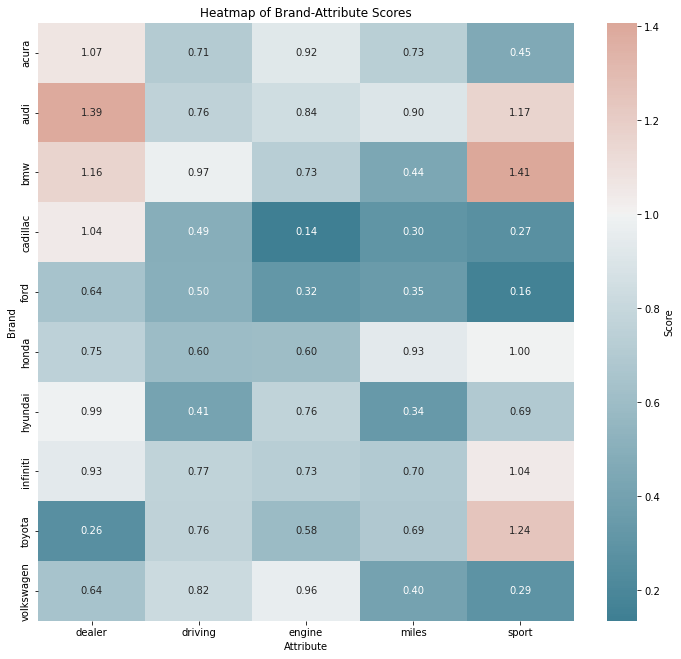

In [47]:
# Creating a pivot table for the heatmap
heatmapData = df.pivot_table(index="Brand", columns="Attribute", values="Score")

cmap = sns.diverging_palette(220, 20, as_cmap=True, center="light")

# Generating the heatmap with the adjusted color palette
plt.figure(figsize=(12, 11))
sns.heatmap(heatmapData, annot=True, cmap=cmap, fmt=".2f", cbar_kws={'label': 'Score'}, center=1)
plt.title('Heatmap of Brand-Attribute Scores')

plt.show()

## Task G

What advice will you give to your client from Task F?

<table><thead><tr><th>Brand</th><th>Attribute</th><th>Lift Score</th><th>Strategic Advice</th></tr></thead><tbody><tr><td>BMW</td><td>Sport</td><td>1.407</td><td>Leverage the brand's strong association with "sportiness" in marketing campaigns.</td></tr><tr><td>Audi</td><td>Dealer</td><td>1.395</td><td>Emphasize the quality of Audi dealerships and customer service to attract more buyers.</td></tr><tr><td>Toyota</td><td>Sport</td><td>1.244</td><td>Explore options to market sportier models or features, given the unexpected strong lift score with "sport."</td></tr><tr><td>Audi</td><td>Sport</td><td>1.165</td><td>Consider co-marketing sporty models alongside your dealer network.</td></tr><tr><td>BMW</td><td>Dealer</td><td>1.161</td><td>Enhance the customer experience at dealerships to solidify the positive association.</td></tr><tr><td>Acura</td><td>Dealer</td><td>1.074</td><td>Improve dealership experiences as this attribute appears to be a strong point for the brand.</td></tr><tr><td>Infiniti</td><td>Sport</td><td>1.042</td><td>Utilize the sporty image in marketing campaigns to attract a younger or more dynamic audience.</td></tr><tr><td>Honda</td><td>Sport</td><td>0.999</td><td>Investigate why the brand nearly has a neutral association with "sport" and consider if repositioning is needed.</td></tr><tr><td>Ford</td><td>Dealer</td><td>0.643</td><td>Focus on improving the customer experience at dealerships to boost this low lift score.</td></tr><tr><td>Cadillac</td><td>Engine</td><td>0.135</td><td>Urgently address the negative perception around the engine quality or performance in your vehicles.</td></tr></tbody></table>

## Task H

Which is the most aspirational brand in your data in terms of people actually wanting to buy or
own? Describe your analysis. What are the business implications for this brand?

In [49]:
aspirationalPhrases = ["goal car", "goal for a car", "car goal", "wish to own", "wished to own", "wishing to own", "hope to buy", "hoped to buy", "hoping to buy",
    "saving for", "saved for", "will save for", "on my wishlist", "was on my wishlist", "will be on my wishlist", "ideal ride", "ideally riding", "ideal for riding", 
    "future car", "car for the future", "future with the car", "next purchase", "next car purchase", "next purchasing", "plan to acquire", "planned to acquire", "planning to acquire",
    "aim to have", "aimed to have", "aiming to have", "covet ownership", "coveted ownership", "coveting ownership", "aspire to drive", "aspired to drive", "aspiring to drive",
    "desire to own", "desired to own", "desiring to own", "eyeing to buy", "eyed to buy", "will eye to buy", "looking to get", "looked to get", "will look to get",
    "long-term plan", "long-term planning", "long-term planned", "investment goal", "investment goals", "invested goal", "bucket list car", "bucket-listed car", "will bucket list car",
    "fantasy vehicle", "fantasized vehicle", "fantasizing about vehicle", "ultimate ride", "ultimately ride", "ultimate for riding", 
    "dream of driving", "dreamed of driving", "dreaming of driving", "set sights on", "set my sights on", "setting sights on", 
    "would love to have", "would have loved to have", "will love to have", "thinking of buying", "thought of buying", "will think of buying", 
    "dream of buying", "dream to own", "dream of driving", "dream to purchase", "dream to acquire", "wish to own", "wish to buy", "wish to drive", "wish to acquire", "wish to purchase",
    "save to buy", "save for ownership", "save to acquire", "save to drive", "save to purchase", "plan to own", "plan to buy", "plan to acquire", "plan to drive", "plan to purchase",
    "hope to own", "hope to buy", "hope to acquire", "hope to drive", "hope to purchase", "aspire to own", "aspire to buy", "aspire to drive", "aspire to acquire", "aspire to purchase",
    "intend to own", "intend to buy", "intend to acquire", "intend to drive", "intend to purchase", 
    "looking to own", "looking to buy", "looking to acquire", "looking to drive", "looking to purchase", 
    "eyeing to own", "eyeing to buy", "eyeing to acquire", "eyeing to drive", "eyeing to purchase",
    "aiming to own", "aiming to buy", "aiming to drive", "aiming to acquire", "aiming to purchase", 
    "desire to own", "desire to buy", "desire to drive", "desire to acquire", "desire to purchase",
    "longing to own", "longing to buy", "longing to drive", "longing to acquire", "longing to purchase", 
    "seeking to own", "seeking to buy", "seeking to drive", "seeking to acquire", "seeking to purchase",
    "coveting to own", "coveting to buy", "coveting to drive", "coveting to acquire", "coveting to purchase",
    "targeting to own", "targeting to buy", "targeting to drive", "targeting to acquire", "targeting to purchase", 
    "strive to own", "strive to buy", "strive to drive", "strive to acquire", "strive to purchase",
    "eager to own", "eager to buy", "eager to drive", "eager to acquire", "eager to purchase", 
    "pining to own", "pining to buy", "pining to drive", "pining to acquire", "pining to purchase",
    "fantasize to own", "fantasize to buy", "fantasize to drive", "fantasize to acquire", "fantasize to purchase",
    "settling to own", "settling to buy", "settling to drive", "settling to acquire", "settling to purchase",
    "yearning to own", "yearning to buy", "yearning to drive", "yearning to acquire", "yearning to purchase",
    "committed to own", "committed to buy", "committed to drive", "committed to acquire", "committed to purchase",
    "contemplating to own", "contemplating to buy", "contemplating to drive", "contemplating to acquire", "contemplating to purchase",
    "envision owning", "envision buying", "envision driving", "envision acquiring", "envision purchasing",
    "motivated to own", "motivated to buy", "motivated to drive", "motivated to acquire", "motivated to purchase",
    "focused on owning", "focused on buying", "focused on driving", "focused on acquiring", "focused on purchasing",
    "on the hunt to own", "on the hunt to buy", "on the hunt to drive", "on the hunt to acquire", "on the hunt to purchase",
    "craving to own", "craving to buy", "craving to drive", "craving to acquire", "craving to purchase", 
    "obliged to own", "obliged to buy", "obliged to drive", "obliged to acquire", "obliged to purchase",
    "resolute to own", "resolute to buy", "resolute to drive", "resolute to acquire", "resolute to purchase"
]

In [50]:
aspirationalPhrases = list(pd.Series(aspirationalPhrases).unique())

In [51]:
aspirationalPhrasesProcessed = set([preprocessText(x) for x in aspirationalPhrases]) 

In [52]:
aspirationalPhrasesProcessed

{'aim',
 'aimed',
 'aiming',
 'aiming acquire',
 'aiming buy',
 'aiming drive',
 'aiming purchase',
 'aspire',
 'aspire acquire',
 'aspire buy',
 'aspire drive',
 'aspire purchase',
 'aspired drive',
 'aspiring drive',
 'bucket list car',
 'bucketlisted car',
 'car future',
 'car goal',
 'committed',
 'committed acquire',
 'committed buy',
 'committed drive',
 'committed purchase',
 'contemplating',
 'contemplating acquire',
 'contemplating buy',
 'contemplating drive',
 'contemplating purchase',
 'covet ownership',
 'coveted ownership',
 'coveting',
 'coveting acquire',
 'coveting buy',
 'coveting drive',
 'coveting ownership',
 'coveting purchase',
 'craving',
 'craving acquire',
 'craving buy',
 'craving drive',
 'craving purchase',
 'desire',
 'desire acquire',
 'desire buy',
 'desire drive',
 'desire purchase',
 'desired',
 'desiring',
 'dream',
 'dream acquire',
 'dream buying',
 'dream driving',
 'dream purchase',
 'dreamed driving',
 'dreaming driving',
 'eager',
 'eager acquir

In [53]:
#Substitute aspiration synonyms with aspiration in commentsData
def replaceAspirationSynonyms(text):
    for phrase in aspirationalPhrasesProcessed:
        text = text.replace(phrase, 'aspiration')
    return text

commentsData['ProcessedTextBrandsAspiration'] = commentsData['ProcessedTextBrands'].apply(replaceAspirationSynonyms)

In [54]:
listOfBrands = list(set(brandModelData['Brand']))

In [55]:
# Initialize dictionaries to hold frequency counts and co-occurrence counts
brandFrequencyDict = {brand: 0 for brand in brandsChosen}
aspirationCount = 0
aspirationBrandOccurrenceDict = {(brand, 'aspiration'): 0 for brand in brandsChosen}

In [56]:
# Function to update co-occurrence counts based on a single post (Revised to consider unique mentions)
def updateAspirationBrandOccurrenceDict(text):
    global brandFrequencyDict, aspirationCount, aspirationBrandOccurrenceDict
    # Extract unique brand mentions in the text
    words = text.split()
    uniqueBrands = list(set([word for word in words if word in brandsChosen]))
    uniqueAspiration = list(set([word for word in words if word == 'aspiration']))

    # Update frequency counts (each brand is counted only once per post)
    for brand in uniqueBrands:
        brandFrequencyDict[brand] += 1

    # Update frequency counts (each feature is counted only once per post)
    for aspiration in uniqueAspiration:
        aspirationCount += 1

    # Update featureBrandOccurrence counts
    for brand, aspiration in aspirationBrandOccurrenceDict.keys():
        # Check if the distance between the two brands in the post is less than or equal to 7 words
        indicesBrand = [i for i, x in enumerate(words) if x == brand]
        indicesAspiration = [i for i, x in enumerate(words) if x == 'aspiration']
        if any(abs(i1 - i2) <= 10 for i1 in indicesBrand for i2 in indicesAspiration):
            aspirationBrandOccurrenceDict[(brand, aspiration)] += 1

# Update frequency and co-occurrence counts based on the posts
commentsData['ProcessedTextBrandsAspiration'].apply(updateAspirationBrandOccurrenceDict)

32      None
31      None
30      None
29      None
28      None
        ... 
5998    None
5997    None
5996    None
5995    None
5994    None
Name: ProcessedTextBrandsAspiration, Length: 6000, dtype: object

In [57]:
aspirationBrandOccurrenceDict

{('bmw', 'aspiration'): 126,
 ('audi', 'aspiration'): 78,
 ('acura', 'aspiration'): 66,
 ('honda', 'aspiration'): 45,
 ('volkswagen', 'aspiration'): 18,
 ('infiniti', 'aspiration'): 24,
 ('cadillac', 'aspiration'): 19,
 ('hyundai', 'aspiration'): 13,
 ('toyota', 'aspiration'): 18,
 ('ford', 'aspiration'): 15}

In [58]:
brandFrequencyDict

{'bmw': 1148,
 'audi': 779,
 'acura': 644,
 'honda': 508,
 'volkswagen': 269,
 'infiniti': 251,
 'cadillac': 225,
 'hyundai': 200,
 'toyota': 235,
 'ford': 192}

In [59]:
aspirationCount

874

In [60]:
totalPosts

6000

In [61]:
brandFrequencyDict

{'bmw': 1148,
 'audi': 779,
 'acura': 644,
 'honda': 508,
 'volkswagen': 269,
 'infiniti': 251,
 'cadillac': 225,
 'hyundai': 200,
 'toyota': 235,
 'ford': 192}

In [62]:
totalPosts = len(commentsData)
liftRatiosBrandAspiration = {}
for (brand, feature), coOccurCount in aspirationBrandOccurrenceDict.items():
    freqBrand = brandFrequencyDict[brand]
    freqAspiration = aspirationCount
    lift = (totalPosts * coOccurCount) / (freqBrand * freqAspiration)
    liftRatiosBrandAspiration[(brand, feature)] = lift
sortedLiftRatiosBrandAspiration = sorted(liftRatiosBrandAspiration.items(), key=lambda x: x[1], reverse=True)

# Filter to keep only unique pairs for lift ratios
# uniqueLiftRatiosBrandFeature = {(min(brand, feature), max(brand, feature)): lift for (brand, feature), lift in sortedLiftRatiosBrandFeature}
# sortedUniqueLiftRatiosBrandFeature = sorted(uniqueLiftRatiosBrandFeature.items(), key=lambda x: x[1], reverse=True)

In [63]:
pd.DataFrame(brandFrequencyDict.items(), columns=['Brand', 'Count']).sort_values(by='Count', ascending=False).head(50)

,Brand,Count
0,bmw,1148
1,audi,779
2,acura,644
3,honda,508
4,volkswagen,269
5,infiniti,251
8,toyota,235
6,cadillac,225
7,hyundai,200
9,ford,192


In [64]:
totalPosts = len(commentsData)
liftRatiosBrandAspiration = {}

for (brand, feature), coOccurCount in aspirationBrandOccurrenceDict.items():
    freqBrand = brandFrequencyDict.get(brand, 0)  # Use get() to return 0 if brand not found
    freqAspiration = aspirationCount
        # Check for zero counts and proceed if both are non-zero
    if freqBrand == 0 or freqAspiration == 0:
        print(f"Skipping lift calculation for {brand} and {feature} due to zero frequency.")
        continue
    
    try:
        lift = (totalPosts * coOccurCount) / (freqBrand * freqAspiration)
        liftRatiosBrandAspiration[(brand, feature)] = lift
    except ZeroDivisionError:
        print(f"ZeroDivisionError encountered for {brand} and {feature}.")
        continue

# Sort the lift ratios
sortedLiftRatiosBrandAspiration = sorted(liftRatiosBrandAspiration.items(), key=lambda x: x[1], reverse=True)


In [65]:
#sortedLiftRatiosBrandAspiration
pd.DataFrame([(brand, attribute, score) for (brand, attribute), score in sortedLiftRatiosBrandAspiration], columns=['Brand', 'Attribute', 'LiftScore'])


,Brand,Attribute,LiftScore
0,bmw,aspiration,0.753474
1,acura,aspiration,0.703555
2,audi,aspiration,0.687380
3,infiniti,aspiration,0.656413
4,honda,aspiration,0.608119
5,cadillac,aspiration,0.579710
6,ford,aspiration,0.536327
7,toyota,aspiration,0.525829
8,volkswagen,aspiration,0.459367
9,hyundai,aspiration,0.446224


Lift values are not providing values between brands and aspiration. Thus using number of posts mentioning aspiration for respective brands is considered as a metric to define how much it is aspired.   

In [66]:
aspirationBrandOccurrenceDict

{('bmw', 'aspiration'): 126,
 ('audi', 'aspiration'): 78,
 ('acura', 'aspiration'): 66,
 ('honda', 'aspiration'): 45,
 ('volkswagen', 'aspiration'): 18,
 ('infiniti', 'aspiration'): 24,
 ('cadillac', 'aspiration'): 19,
 ('hyundai', 'aspiration'): 13,
 ('toyota', 'aspiration'): 18,
 ('ford', 'aspiration'): 15}

In [67]:
pd.DataFrame([(brand, attribute, post) for (brand, attribute), post in aspirationBrandOccurrenceDict.items()], columns=['Brand', 'Attribute', '# of posts']).sort_values(by='# of posts', ascending=False)


,Brand,Attribute,# of posts
0,bmw,aspiration,126
1,audi,aspiration,78
2,acura,aspiration,66
3,honda,aspiration,45
5,infiniti,aspiration,24
6,cadillac,aspiration,19
4,volkswagen,aspiration,18
8,toyota,aspiration,18
9,ford,aspiration,15
7,hyundai,aspiration,13


### Conclusion:

A holistic view of the data shows a clear demarcation between luxury and mainstream brands. While luxury brands excel in attributes like aspiration and sportiness, mainstream brands are more evenly spread across various attributes. There's an opportunity for brands to leverage their strengths and address their weaknesses. For instance, Cadillac could look into improving the perception of their engine quality. Similarly, Audi, with its cross-segment appeal, could strategize to target a broader consumer base. Brands should also explore partnerships based on high lift values to tap into complementary market segments.